In [8]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import csv
from torch import nn
from sklearn.utils import class_weight
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

torch.manual_seed(0)

DATA_PATH = '/home/skrhakv/deeplife/deeplife-project/data'
ESM_EMBEDDINGS_PATH = '/home/skrhakv/esm2/embeddings-3B-deeplife'
PROTBERT_EMBEDDINGS_PATH = '/home/skrhakv/protbert/embeddings-deeplife'
MODELS_PATH = '/home/skrhakv/deeplife/deeplife-project/models'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Train a classifier on HOLO sequence and evaluate on APO vs. HOLO sequences

### Load the dataset

In [13]:
class SequenceCryptoBenchDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        Xs_list = None
        Ys_list = None
        for key in _Xs.keys():
            if Xs_list is None:
                Xs_list = _Xs[key]
                Ys_list = _Ys[key]
            else:
                Xs_list = np.concatenate((Xs_list,_Xs[key]), axis = 0)
                Ys_list = np.concatenate((Ys_list,_Ys[key]), axis = 0)

        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y

def process_sequence_dataset(annotation_path, embeddings_paths):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id],embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for residue_idx in [int(residue[1:]) for residue in row[3].split(' ')]:
                # Yu dataset has 1-based indexing, so we need to subtract 1
                Ys[id][residue_idx - 1] = 1

    return Xs, Ys

In [ ]:
Xs_train_holo, Ys_train_holo = process_sequence_dataset(f'{DATA_PATH}/holo_train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_holo = SequenceCryptoBenchDataset(Xs_train_holo, Ys_train_holo)

Xs_test_holo, Ys_test_holo = process_sequence_dataset(f'{DATA_PATH}/holo_test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_holo = SequenceCryptoBenchDataset(Xs_test_holo, Ys_test_holo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/apo_test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

In [20]:
DROPOUT = 0.3
LAYER_WIDTH = 100
ESM2_DIM = 2560
class CryptoBenchClassifier(nn.Module):
    def __init__(self, input_dim=ESM2_DIM):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout1(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)

### TRAIN
Train the method on HOLO sequences, evaluate on APO and HOLO test set.

In [15]:
model_0 = CryptoBenchClassifier().to(device)
epochs = 80

# Create an optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.0001)

X_train, y_train = train_dataset_holo[:]
X_test_holo, y_test_holo = test_dataset_holo[:]
X_test_apo, y_test_apo = test_dataset_apo[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test_holo, y_test_holo = X_test_holo.to(device), y_test_holo.to(device).float()
X_test_apo, y_test_apo = X_test_apo.to(device), y_test_apo.to(device).float()

train_losses, test_losses_holo, test_losses_apo = [], [], []

for epoch in range(epochs):

    #
    # TRAIN
    #
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    train_losses.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #
    # TEST
    #
    model_0.eval()
    with torch.inference_mode():
        #
        # test for HOLO
        #
        test_logits = model_0(X_test_holo).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss_holo = loss_fn(test_logits,
                            y_test_holo)
        test_losses_holo.append(test_loss_holo.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc_holo = accuracy_fn(y_true=y_test_holo,
                               y_pred=test_pred)
        fpr_holo, tpr_holo, thresholds_holo = metrics.roc_curve(y_test_holo.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc_holo = metrics.auc(fpr_holo, tpr_holo)

        mcc_holo = metrics.matthews_corrcoef(y_test_holo.cpu().numpy(), test_pred.cpu().numpy())
        
        #
        # test for APO
        #
        test_logits = model_0(X_test_apo).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss_apo = loss_fn(test_logits,
                            y_test_apo)
        test_losses_apo.append(test_loss_apo.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc_apo = accuracy_fn(y_true=y_test_apo,
                               y_pred=test_pred)
        fpr_apo, tpr_apo, thresholds_apo = metrics.roc_curve(y_test_apo.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc_apo = metrics.auc(fpr_apo, tpr_apo)

        mcc_apo = metrics.matthews_corrcoef(y_test_apo.cpu().numpy(), test_pred.cpu().numpy())
    if epoch % 10 == 0:
        print(f"APO  - Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc_apo:.2f}% | Test loss: {test_loss_apo:.5f}, AUC: {roc_auc_apo}, MCC: {mcc_apo}")
        print(f"HOLO - Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc_holo:.2f}% | Test loss: {test_loss_holo:.5f}, AUC: {roc_auc_holo}, MCC: {mcc_holo}")

APO  - Epoch: 0 | Loss: 1.64932, Accuracy: 76.39% | Test loss: 1.43711, AUC: 0.5087620197900277, MCC: 0.007944087819668095
HOLO - Epoch: 0 | Loss: 1.64932, Accuracy: 77.19% | Test loss: 1.13558, AUC: 0.5176923332644465, MCC: 0.0088797542216307
APO  - Epoch: 10 | Loss: 1.13196, Accuracy: 84.11% | Test loss: 1.13239, AUC: 0.6930399198072822, MCC: 0.13596154673292912
HOLO - Epoch: 10 | Loss: 1.13196, Accuracy: 84.43% | Test loss: 0.90596, AUC: 0.6939245273284317, MCC: 0.11161712783955766
APO  - Epoch: 20 | Loss: 0.94791, Accuracy: 87.45% | Test loss: 1.06449, AUC: 0.7467311067345894, MCC: 0.1900169418266273
HOLO - Epoch: 20 | Loss: 0.94791, Accuracy: 87.76% | Test loss: 0.84600, AUC: 0.7457237241072553, MCC: 0.16063140515083624
APO  - Epoch: 30 | Loss: 0.85007, Accuracy: 86.64% | Test loss: 1.00690, AUC: 0.7725604041805625, MCC: 0.22555423487252216
HOLO - Epoch: 30 | Loss: 0.85007, Accuracy: 86.75% | Test loss: 0.81100, AUC: 0.770961100918847, MCC: 0.189113113330246
APO  - Epoch: 40 | Los

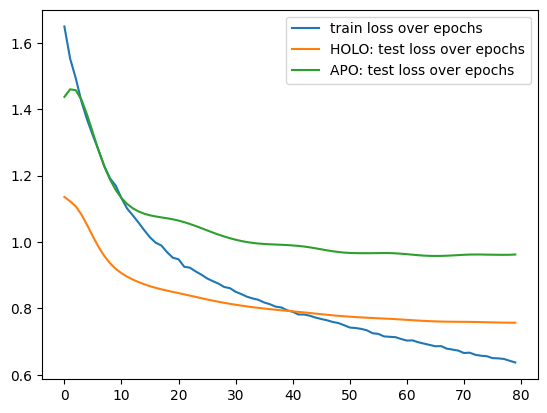

In [16]:
plt.plot(train_losses,label="train loss over epochs")
plt.plot(test_losses_holo,label="HOLO: test loss over epochs")
plt.plot(test_losses_apo,label="APO: test loss over epochs")
plt.legend()

### plot ROC curve
As you can se below, the performance for APO and HOLO is nearly identical  

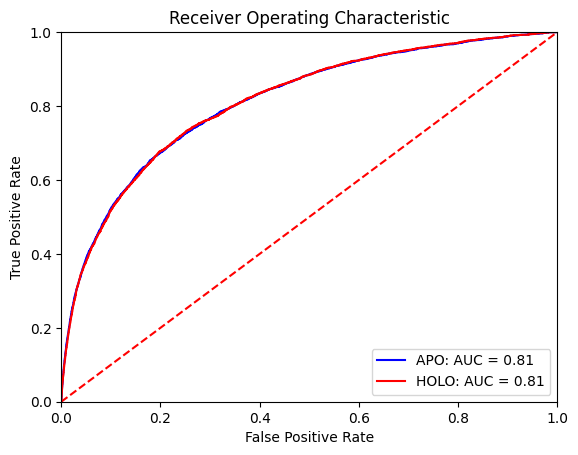

In [18]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_apo, tpr_apo, 'b', label = 'APO: AUC = %0.2f' % roc_auc_apo)
plt.plot(fpr_holo, tpr_holo, 'r', label = 'HOLO: AUC = %0.2f' % roc_auc_holo)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Save the model & cleanup

In [19]:
torch.save(model_0.state_dict(), f'{MODELS_PATH}/holo_sequence_model.pth')

# TODO: delete all the 'heavy' variables to free RAM

# TRAIN STRUCTURE-BASED METHOD

In [17]:
import gc
import pickle
import os

NUMBER_OF_SPLITS = 8

HOLO_VOXEL_FEATURES_PATH = '/home/skrhakv/deeplife/deeplife-project/data/holo-voxel-features'
HOLO_VOXEL_ANNOTATIONS_PATH = '/home/skrhakv/deeplife/deeplife-project/data/holo-voxel-annotations'
WINDOW_SIZE = 32
WINDOW_STEP = 16

# splits the protein into 3D windows
def sliding_window_3d(vector):
    vector = vector.unfold(1,WINDOW_SIZE,WINDOW_STEP)
    vector = vector.unfold(2,WINDOW_SIZE,WINDOW_STEP)
    vector = vector.unfold(3,WINDOW_SIZE,WINDOW_STEP)
    return vector.flatten(1, 3)


def pad_and_sliding_window_3d(x, y):
    pad1 = WINDOW_SIZE - x.shape[3] % WINDOW_SIZE if WINDOW_SIZE - x.shape[3] % WINDOW_SIZE > 0 else 0
    pad2 = WINDOW_SIZE - x.shape[2] % WINDOW_SIZE if WINDOW_SIZE - x.shape[2] % WINDOW_SIZE > 0 else 0
    pad3 = WINDOW_SIZE - x.shape[1] % WINDOW_SIZE if WINDOW_SIZE - x.shape[1] % WINDOW_SIZE > 0 else 0

    x = torch.tensor(x, dtype=torch.float16)
    y = torch.tensor(y, dtype=torch.int8)

    # add padding to the voxel grid
    x = F.pad(x, (int(pad1 / 2), int(pad1 / 2) + (pad1 % 2 > 0),
        int(pad2 / 2), int(pad2 / 2) + (pad2 % 2 > 0),
        int(pad3 / 2), int(pad3 / 2) + (pad3 % 2 > 0)), mode='constant', value=0)
    y = F.pad(y, (int(pad1 / 2), int(pad1 / 2) + (pad1 % 2 > 0),
        int(pad2 / 2), int(pad2 / 2) + (pad2 % 2 > 0),
        int(pad3 / 2), int(pad3 / 2) + (pad3 % 2 > 0)), mode='constant', value=0)

    # split the protein into 3D windows
    x = sliding_window_3d(x)
    y = sliding_window_3d(y)

    return x,y

class VoxelCryptoBenchDataset(Dataset):
    def __init__(self, _Xs= None, _Ys= None):
        self.Xs = None
        self.Ys = None

        if _Xs is None or _Ys is None:
            return
        counter = 1
        keys = list(_Xs.keys())
        for key in keys:
            print(key, ' ',counter, ' / ', len(keys), ' ')
            counter += 1

            x, y = pad_and_sliding_window_3d(_Xs[key], _Ys[key])
            y = y.sum(dim=[0,2,3,4]) > 0
            if self.Xs is None:
                self.Xs = x
                self.Ys = y
            else:
                self.Xs = torch.cat((self.Xs,x),1)
                self.Ys = torch.cat((self.Ys,y))

            if counter % 5 == 0:
                gc.collect()

            del _Xs[key]
            del _Ys[key]

        self.Xs = self.Xs.swapaxes(0,1)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y
    
class VoxelCryptoBenchCNN(nn.Module):
    def __init__(self):
        super(VoxelCryptoBenchCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=8,
                               out_channels=2,
                               kernel_size = 5,
                               stride=2,
                               padding=2)



        self.maxpool1 = nn.MaxPool3d(kernel_size=3, stride=1, padding=1)

        self.dropout1 = nn.Dropout(0.25)

        self.linear1 = nn.Linear(8192, 2048)
        self.dropout2 = nn.Dropout(0.25)

        self.linear2 = nn.Linear(2048, 1)


    def forward(self, x):
        x = self.conv1(x)

        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = torch.flatten(x,1)

        x = self.linear1(x)
        x = self.dropout2(x)
        x = F.relu(x)

        x = self.linear2(x)
        return x


def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def proccess_voxel_dataset(annotation_path, voxel_features_path, voxel_annotation_path):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            filename = id + '.npy'
            
            if not os.path.isfile(f'{voxel_features_path}/{filename}') or \
                not os.path.isfile(f'{voxel_annotation_path}/{filename}'):
                print(f'{id} not present, skipping ...')
                continue
            if id not in Xs:
                voxel_features = np.load(f'{voxel_features_path}/{filename}')
                Xs[id] = np.transpose(voxel_features, (3, 1, 2, 0))

            if id not in Ys:
                voxel_annotations = np.load(f'{voxel_annotation_path}/{filename}')
                Ys[id] = np.transpose(voxel_annotations, (3, 1, 2, 0))


    return Xs, Ys

print('Loading dataset from .npy files ...')
holo_Xs_train, holo_Ys_train = proccess_voxel_dataset(f'{DATA_PATH}/holo_train.txt', HOLO_VOXEL_FEATURES_PATH, HOLO_VOXEL_ANNOTATIONS_PATH)

print('Create VoxelYuDataset instance ...')
holo_train_dataset = VoxelCryptoBenchDataset(holo_Xs_train, holo_Ys_train)

In [7]:
with open(f'{DATA_PATH}/holo_train_dataset.pickle', 'wb') as handle:
    pickle.dump(holo_train_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
X_train_holo, y_train_holo = holo_train_dataset[:]

np_list = []
for i in y_train_holo:
    np_list.append(i.numpy().flatten())
    
y_train_concatenated = np.concatenate(np_list)

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train_concatenated).to(device)

In [ ]:
BATCH_SIZE = 2048

model_1 = VoxelCryptoBenchCNN().to(device)

# Create an optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.0001)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
epochs = 5


for epoch in range(epochs):
    ### TRAIN
    print(f"Epoch {epoch}")

    model_1.train()

    for i in range(NUMBER_OF_SPLITS):

        train_dataloader = DataLoader(holo_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
            print(f"Epoch {epoch}, batch {id_batch} / {BATCH_SIZE}")

            X_train, y_train = x_batch.to(device), y_batch.to(device).float()

            y_logits = model_1(X_train.float()).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits,
                            y_train)
            acc = accuracy_fn(y_true=y_train,
                                y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

### Save the trained model

In [15]:
MODELS_PATH = '/home/skrhakv/deeplife/deeplife-project/models'

torch.save(model_1.state_dict(), f'{MODELS_PATH}/holo_structure_model.pth')

### load holo test set

In [18]:
print('Loading dataset from .npy files ...')
holo_Xs_test, holo_Ys_test = proccess_voxel_dataset(f'{DATA_PATH}/holo_test.txt', HOLO_VOXEL_FEATURES_PATH, HOLO_VOXEL_ANNOTATIONS_PATH)

print('Create VoxelCryptoBenchDataset instance ...')
holo_test_dataset = VoxelCryptoBenchDataset(holo_Xs_test, holo_Ys_test)

Loading dataset from .npy files ...
6mu3H not present, skipping ...
7fsiD not present, skipping ...
7fsiD not present, skipping ...
8bbzCCC not present, skipping ...
2znzA not present, skipping ...
5o6oA not present, skipping ...
5o6oA not present, skipping ...
6g4lA not present, skipping ...
6g4lA not present, skipping ...
6u1dA not present, skipping ...
6u1dA not present, skipping ...
6u1dA not present, skipping ...
6u1dA not present, skipping ...
6u1dA not present, skipping ...
8evxA not present, skipping ...
8evxA not present, skipping ...
8evxA not present, skipping ...
7fc9A not present, skipping ...
7fc9A not present, skipping ...
7fc9A not present, skipping ...
7fc9A not present, skipping ...
7fc9A not present, skipping ...
7fc9A not present, skipping ...
7fc9A not present, skipping ...
3mvrA not present, skipping ...
3mvrA not present, skipping ...
3tmzA not present, skipping ...
3tmzA not present, skipping ...
6bwwA not present, skipping ...
6bwwA not present, skipping ...
5c

In [19]:
with open(f'{DATA_PATH}/holo_test_dataset.pickle', 'wb') as handle:
    pickle.dump(holo_test_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
model_1.eval()

with torch.inference_mode():

    # prepare the test 
    test_dataloader = DataLoader(holo_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # make the predictions (batch the predictions just in case GPU doesn't have enough memory)
    test_logits = None
    y_test = None

    for id_batch, (x_batch, y_batch) in enumerate(test_dataloader):
        if test_logits == None:
            test_logits = model_1(x_batch.float().to(device)).squeeze().to(device)
            y_test = y_batch
        else:
            test_logits = torch.cat((test_logits, model_1(x_batch.float().to(device)).squeeze()))
            y_test = torch.cat((y_test, y_batch))
    
    # compute the metrics
    test_pred = torch.round(torch.sigmoid(test_logits))
    y_test = y_test.to(device).float()
    test_loss = loss_fn(test_logits,
                        y_test.to(device))
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
    fpr_1, tpr_1, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
    roc_auc_1 = metrics.auc(fpr_1, tpr_1)
    mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    
    print(f"Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc_1}, MCC: {mcc}")

Accuracy: 91.19% | Test loss: 0.80221, AUC: 0.8089356415090461, MCC: 0.4313341662553757


### Stats

In [27]:
print('Windows per protein: ', len(holo_test_dataset) / 369)
print(f'Class weights: ', class_weights)

Windows per protein:  100.34959349593495
Class weights:  tensor([0.6551, 2.1119], device='cuda:0')


In [ ]:
# TODO: Evaluate model_1 on APO

# Train a classifier on APO sequences and evaluate on APO sequences

In [4]:
Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'{DATA_PATH}/apo_train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/apo_test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

In [5]:
model_3 = CryptoBenchClassifier().to(device)
epochs = 80

# Create an optimizer
optimizer = torch.optim.Adam(params=model_3.parameters(),
                            lr=0.0001)

X_train, y_train = train_dataset_apo[:]
X_test, y_test, = test_dataset_apo[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
print(f'Class weights: ', class_weights)
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test, y_test = X_test.to(device), y_test.to(device).float()

train_losses, test_losses = [], []

for epoch in range(epochs):

    #
    # TRAIN
    #
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    train_losses.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #
    # TEST
    #
    model_3.eval()
    with torch.inference_mode():

        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_losses.append(test_loss.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}")


Class weights:  tensor([ 0.5235, 11.1424], device='cuda:0')
Epoch: 0 | Loss: 1.69492, Accuracy: 86.73% | Test loss: 1.33670, AUC: 0.5159522644324385, MCC: 0.01770743487905398
Epoch: 10 | Loss: 1.14121, Accuracy: 87.68% | Test loss: 1.00385, AUC: 0.6938056490694717, MCC: 0.1517654000622616
Epoch: 20 | Loss: 0.93119, Accuracy: 85.92% | Test loss: 0.89922, AUC: 0.7435034279963523, MCC: 0.20189837551908305
Epoch: 30 | Loss: 0.84126, Accuracy: 87.65% | Test loss: 0.86819, AUC: 0.76829202732843, MCC: 0.23019546356593745
Epoch: 40 | Loss: 0.78492, Accuracy: 87.11% | Test loss: 0.83982, AUC: 0.785796149644903, MCC: 0.2529609861931502
Epoch: 50 | Loss: 0.74749, Accuracy: 87.31% | Test loss: 0.82530, AUC: 0.7967984310493996, MCC: 0.26300369539206037
Epoch: 60 | Loss: 0.70627, Accuracy: 87.40% | Test loss: 0.81532, AUC: 0.8043782575281853, MCC: 0.2727246216798862
Epoch: 70 | Loss: 0.67913, Accuracy: 87.46% | Test loss: 0.80903, AUC: 0.8097370111553522, MCC: 0.2803142701071516


In [15]:
Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'{DATA_PATH}/apo_train.txt', [ESM_EMBEDDINGS_PATH, PROTBERT_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/apo_test.txt', [ESM_EMBEDDINGS_PATH, PROTBERT_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

In [18]:
print(y_train.shape)
X_train.shape

torch.Size([343096])


torch.Size([343096, 3584])

In [22]:
# TODO: REFACTOR!!!! do not copypaste

PROTBERT_DIM = 1024
model_3 = CryptoBenchClassifier(ESM2_DIM + PROTBERT_DIM).to(device)
epochs = 80

# Create an optimizer
optimizer = torch.optim.Adam(params=model_3.parameters(),
                            lr=0.0001)

X_train, y_train = train_dataset_apo[:]
X_test, y_test, = test_dataset_apo[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
print(f'Class weights: ', class_weights)
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test, y_test = X_test.to(device), y_test.to(device).float()

train_losses, test_losses = [], []

for epoch in range(epochs):

    #
    # TRAIN
    #
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    train_losses.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #
    # TEST
    #
    model_3.eval()
    with torch.inference_mode():

        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_losses.append(test_loss.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}")


Class weights:  tensor([ 0.5235, 11.1424], device='cuda:0')
Epoch: 0 | Loss: 1.61662, Accuracy: 79.92% | Test loss: 1.17784, AUC: 0.5038993604307269, MCC: 0.010175904204136286
Epoch: 10 | Loss: 1.08228, Accuracy: 86.67% | Test loss: 0.94615, AUC: 0.710628990130082, MCC: 0.1670622288203912
Epoch: 20 | Loss: 0.92433, Accuracy: 89.76% | Test loss: 0.91458, AUC: 0.7546681811339828, MCC: 0.2169483034857778
Epoch: 30 | Loss: 0.83670, Accuracy: 87.17% | Test loss: 0.85599, AUC: 0.7782522754807413, MCC: 0.24078503180415772
Epoch: 40 | Loss: 0.77656, Accuracy: 88.20% | Test loss: 0.84385, AUC: 0.7921494514002471, MCC: 0.25905439092796007
Epoch: 50 | Loss: 0.73579, Accuracy: 87.39% | Test loss: 0.82227, AUC: 0.8013620823719902, MCC: 0.27031938538427497
Epoch: 60 | Loss: 0.69949, Accuracy: 87.81% | Test loss: 0.81706, AUC: 0.8076489928023405, MCC: 0.2772930530401911
Epoch: 70 | Loss: 0.66862, Accuracy: 87.74% | Test loss: 0.81132, AUC: 0.8120311871806218, MCC: 0.2830758635469552
